Object detection using Transfer Learning of CNN architectures
a. Load in a pre-trained CNN model trained on a large dataset
b. Freeze parameters (weights) in model’s lower convolutional layers
c. Add custom classifier with several layers of trainable parameters to model
d. Train classifier layers on training data available for task
e. Fine-tune hyper parameters and unfreeze more layers as needed


Transfer Learning:
Transfer learning in object detection is a technique where a pre-trained deep learning model, typically a convolutional neural network (CNN), is used as a starting point for training a new object detection model. Instead of training a deep neural network from scratch, transfer learning leverages the knowledge and features learned by the pre-trained model on a large dataset.

Here's how transfer learning works in object detection:

Pre-trained Model: A pre-trained CNN model, such as VGG, ResNet, or MobileNet, that has been trained on a large dataset, often for image classification, is selected as the starting point.

Feature Extraction: The pre-trained model's layers, especially the earlier convolutional layers, are retained. These layers have learned to extract meaningful features from images. They act as feature extractors for the object detection task.

Adaptation: A new set of layers, including object detection-specific layers like anchor boxes, region proposal networks (RPNs), and classification/regression heads, are added on top of the retained layers. These layers are specific to the object detection task and are trained from scratch.

Fine-Tuning: The entire model is trained on a smaller dataset for the specific object detection task. This fine-tuning allows the model to adapt to the new object classes and detection challenges.

In [1]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Make predictions using ready made model (without any training)

In [2]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=IMAGE_SHAPE+(3,))
])

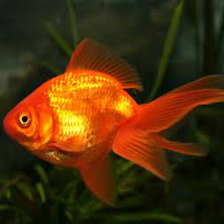

In [3]:
gold_fish = Image.open("/content/goldfish.jpeg").resize(IMAGE_SHAPE)
gold_fish

In [4]:
gold_fish = np.array(gold_fish)/255.0
gold_fish.shape

(224, 224, 3)

In [5]:
gold_fish[np.newaxis, ...]

array([[[[0.10588235, 0.1254902 , 0.10196078],
         [0.10588235, 0.1254902 , 0.10196078],
         [0.10588235, 0.1254902 , 0.10196078],
         ...,
         [0.20392157, 0.25882353, 0.2       ],
         [0.20392157, 0.25882353, 0.2       ],
         [0.18823529, 0.24313725, 0.18431373]],

        [[0.10588235, 0.1254902 , 0.10196078],
         [0.10588235, 0.1254902 , 0.10196078],
         [0.10588235, 0.1254902 , 0.10196078],
         ...,
         [0.21176471, 0.26666667, 0.20784314],
         [0.20784314, 0.2627451 , 0.20392157],
         [0.19215686, 0.24705882, 0.18823529]],

        [[0.10588235, 0.1254902 , 0.10196078],
         [0.10588235, 0.1254902 , 0.10196078],
         [0.10588235, 0.1254902 , 0.10196078],
         ...,
         [0.21568627, 0.27058824, 0.21176471],
         [0.21568627, 0.27058824, 0.21176471],
         [0.19215686, 0.24705882, 0.18823529]],

        ...,

        [[0.05882353, 0.06666667, 0.01568627],
         [0.05490196, 0.0627451 , 0.01176471]

In [6]:
result = classifier.predict(gold_fish[np.newaxis, ...])
result.shape

1/1 [==============================] - 3s 3s/step


(1, 1001)

In [7]:
predicted_label_index = np.argmax(result)
predicted_label_index

2

In [8]:
image_labels = []
with open("ImageNetLabels.txt", "r") as f:
    image_labels = f.read().splitlines()
image_labels[:5]

['background', 'tench', 'goldfish', 'great white shark', 'tiger shark']

In [9]:
image_labels[predicted_label_index]

'goldfish'

Load flowers dataset

In [10]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)
# cache_dir indicates where to download data. I specified . which means current directory
# untar true will unzip it

228813984/228813984 [==============================] - 5s 0us/step


In [11]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('datasets/flower_photos')

In [12]:
list(data_dir.glob('*/*.jpg'))[:5]

[PosixPath('datasets/flower_photos/tulips/8523133474_d2c0845b54.jpg'),
 PosixPath('datasets/flower_photos/tulips/14097328354_4f1469a170.jpg'),
 PosixPath('datasets/flower_photos/tulips/17078576150_6f272ce73f_n.jpg'),
 PosixPath('datasets/flower_photos/tulips/8673416556_639f5c88f1_n.jpg'),
 PosixPath('datasets/flower_photos/tulips/7166626128_8e0983ac8e_n.jpg')]

In [13]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [14]:
roses = list(data_dir.glob('roses/*'))
roses[:5]

[PosixPath('datasets/flower_photos/roses/18741313803_1bbf842fc6_n.jpg'),
 PosixPath('datasets/flower_photos/roses/5332550500_ab341aefd8.jpg'),
 PosixPath('datasets/flower_photos/roses/5897035797_e67bf68124_n.jpg'),
 PosixPath('datasets/flower_photos/roses/4979895172_ca06eba616.jpg'),
 PosixPath('datasets/flower_photos/roses/4495885281_fe2a3b671d.jpg')]

In [15]:
!pip install Pillow

In [16]:
from PIL import Image

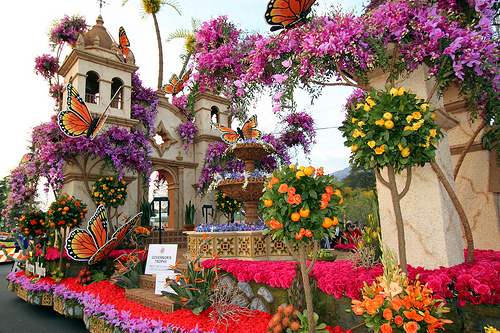

In [17]:
Image.open(str(roses[1]))

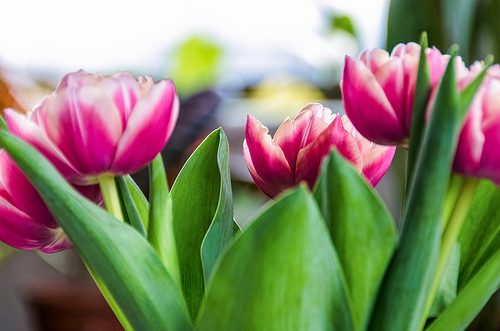

In [18]:
tulips = list(data_dir.glob('tulips/*'))
Image.open(str(tulips[0]))

Read flowers images from disk into numpy array using opencv

In [19]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

In [20]:
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [21]:
flowers_images_dict['roses'][:5]

[PosixPath('datasets/flower_photos/roses/18741313803_1bbf842fc6_n.jpg'),
 PosixPath('datasets/flower_photos/roses/5332550500_ab341aefd8.jpg'),
 PosixPath('datasets/flower_photos/roses/5897035797_e67bf68124_n.jpg'),
 PosixPath('datasets/flower_photos/roses/4979895172_ca06eba616.jpg'),
 PosixPath('datasets/flower_photos/roses/4495885281_fe2a3b671d.jpg')]

In [22]:
str(flowers_images_dict['roses'][0])

'datasets/flower_photos/roses/18741313803_1bbf842fc6_n.jpg'

In [23]:
img = cv2.imread(str(flowers_images_dict['roses'][0]))

In [24]:
img.shape

(213, 320, 3)

In [25]:
cv2.resize(img,(224,224)).shape

(224, 224, 3)

In [26]:
X, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

In [27]:
X = np.array(X)
y = np.array(y)

Train test split

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

Preprocessing the data


In [29]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

Make prediction using pre-trained model on new flowers dataset

In [30]:
X[1].shape

(224, 224, 3)

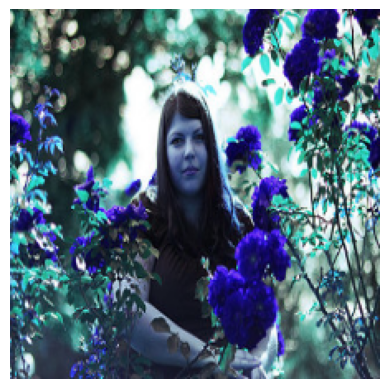

In [31]:
plt.axis('off')
plt.imshow(X[0])

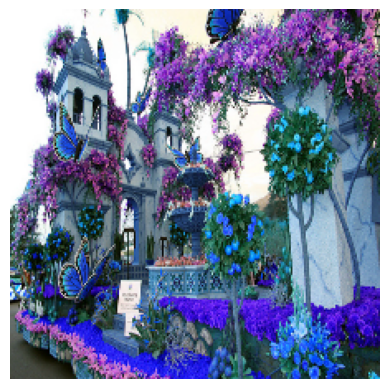

In [32]:
plt.axis('off')
plt.imshow(X[1])

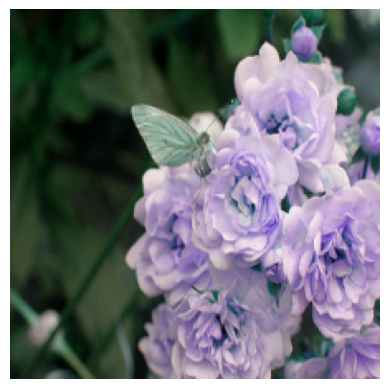

In [33]:
plt.axis('off')
plt.imshow(X[2])

In [34]:
x0_resized = cv2.resize(X[0], IMAGE_SHAPE)
x1_resized = cv2.resize(X[1], IMAGE_SHAPE)
x2_resized = cv2.resize(X[2], IMAGE_SHAPE)

In [35]:
predicted = classifier.predict(np.array([x0_resized, x1_resized, x2_resized]))
predicted = np.argmax(predicted, axis=1)
predicted

1/1 [==============================] - 3s 3s/step


array([795, 795, 795])

In [36]:
image_labels[795]

'shower curtain'

Now take pre-trained model and retrain it using flowers images

In [37]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [38]:
num_of_flowers = 5

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_flowers)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [39]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
86/86 [==============================] - 131s 1s/step - loss: 0.8628 - acc: 0.6781
Epoch 2/5
86/86 [==============================] - 122s 1s/step - loss: 0.4156 - acc: 0.8663
Epoch 3/5
86/86 [==============================] - 125s 1s/step - loss: 0.3230 - acc: 0.8975
Epoch 4/5
86/86 [==============================] - 124s 1s/step - loss: 0.2722 - acc: 0.9190
Epoch 5/5
86/86 [==============================] - 122s 1s/step - loss: 0.2394 - acc: 0.9313


In [40]:
model.evaluate(X_test_scaled,y_test)

29/29 [==============================] - 43s 1s/step - loss: 0.3617 - acc: 0.8725


[0.36165452003479004, 0.8725489974021912]